* gdrive
    * MyDrive
        * CSVS
        * TSVS
        * data
            * 2019
                * apri
                    * reviews.csv
                * febrouary
                    * reviews.csv
                * march
                    * reviews.csv
            * 2023
                * june
                    * reviews.csv
                * march
                    * reviews.csv
                * september
                    * reviews.csv
            * negative.txt
            * positive.txt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install langdetect
!pip install nltk

import nltk
nltk.download('stopwords')
nltk.download('punkt')

!pip install gensim


import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=9cc0bac0a563809a74f815f90db8371c72deba6a15b49302c7085fc1cfebd58d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Ερώτημα 1 (kai gia tis 2 xronies)

#Sunartisi (fix_data) pou ftiaxnei mono me sxoleia ena csv kai to apothikeuei
#Sunartisi (cleaning) katharizei ton "thoribo"
#Sunartisi (get_sentiment) gia kathe sxoleio mas epistrefi thn katigoria poy anoikei

from langdetect import detect

def fix_data(file_path, percentage, months: list):

    combined_comments = []  # To store the data
    for month in months:
        reviews_file_path = file_path + month + "/reviews.csv"#get the path
        comments = pd.read_csv(reviews_file_path)#read the csv

        num_rows_to_keep = percentage
        comments = comments.sample(n=num_rows_to_keep)#sample the rows

        for column in comments.columns: # Keep only the column "comments"
            if column != "comments":
                comments = comments.drop(column, axis=1)#drop it
        comments = comments.dropna() #drop nan values
        combined_comments.append(comments) #append the df to the list

    comments = pd.concat(combined_comments) #concat the dataframe
    comments = comments.drop_duplicates()

    for comment in comments["comments"]:
        try:
            detection=detect(comment)#detect the language
            if detection != "en":#if it is not english
                comments = comments.drop(comments[comments["comments"] == comment].index)#drop it
        except:
            comments = comments.drop(comments[comments["comments"] == comment].index)

    if "2019" in file_path:#if it is 2019
        comments.to_csv("/content/gdrive/MyDrive/CSVS/train_2019.csv", index=False)
    else:
        comments.to_csv("/content/gdrive/MyDrive/CSVS/train_2023.csv", index=False)



import re
import nltk
from nltk.corpus import stopwords
from transformers import pipeline


def cleaning(text):
    text = str(text).lower()#convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)#remove punctuation
    text = re.sub(r'\@\w+|\#', '', text)#remove hashtags and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)#remove urls
    text = re.sub(r'\d+', '', text)#remove digits
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)#remove emojis

    stopwords_cleaning = stopwords.words('english')#remove stopwords
    text_word = text.split()#split the text
    filter_words = [word for word in text_word if word not in stopwords_cleaning]#filter the stopwords
    text = ' '.join(filter_words)#join the words

    return text#return the cleaned text


def get_sentiment(df):
    pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")#load the sentiment analysis model
    def func(text):#function to get the sentiment
        try:#try to get the sentiment
            return pipe(text)[0]['label']
        except:
            return 'error'
    df['sentiment'] = df['comments'].apply(func)#apply the function to the comments
    return df

In [ ]:
#ftiaxnoyme 2 arxeia CSV me sxoleia gia to 2019,2023
file_path_2019 = "/content/gdrive/MyDrive/data/2019"
file_path_2023 = "/content/gdrive/MyDrive/data/2023"

months_2019 = ['/april', '/febrouary', '/march']
months_2023 = ['/june', '/march', '/september']

#auto to komati pernei ligi ora (pano-kato 20 lepta,to trejame polles fores kai den eixame thema me thn ram,ama thelete kante to 15000,8000 antoistixa
#prokeimenoy meta thn sunartiti (cook) na exoyme pano apo 450 comments) (me auta poy exoyme parakato exoyme sxedon 1000comments)
fix_data(file_path_2019, 20000, months_2019)
fix_data(file_path_2023, 10000,months_2023)

In [ ]:
#katharizoyme ta CSV pou ftiaksame prin.Fortonoyme to thetiko kai arnitiko synolo lekseon.

#Synartisi (cook) sumfona me to silono thetikon kai arntikikon lekseon poy exei mia protasi se sxesi me ayta poy fortosame prin thn katatasoyme se mia apo tis 3 katigories (NEUTRAL,POSITIVE,NEGATIVE).Kai meta moinoyme ligo-ligo kata ena 10% ta thetika sxoleia prokeimenou na ftasoume sto epithimito apotelesema (50%).
#Enan antistixo mixanismo efarmozoyme kai gia NEUTRAL alla me orio (30%).Sto telos apla prosuetoume mia akoma stilei opou prosthetoume to ID sto telos apothikeuoume se CSV morfi ena arxeio me (ID,COMMENT,SENTIMENT)

train_2019 = pd.read_csv("/content/gdrive/MyDrive/CSVS/train_2019.csv")
train_2019['comments']=train_2019['comments'].apply(cleaning)#cleaning the comments

train_2023 = pd.read_csv("/content/gdrive/MyDrive/CSVS/train_2023.csv")#read the file
train_2023['comments']=train_2023['comments'].apply(cleaning)#cleaning the comments

with open("/content/gdrive/MyDrive/data/positive.txt", 'r') as file:#open the file
    positive_words = set(file.read().splitlines())#read the file and split the lines
with open("/content/gdrive/MyDrive/data/negative.txt", 'r') as file:#open the file
    negative_words = set(file.read().splitlines())#read the file and split the lines


def persentage(x):#function to calculate the percentage
        return round((x/size)*100,2)

def cook(df,year):
    global size

    rows=[]#to store the data
    for comments in df['comments']:#for each comment
        word=set(comments.split())#split the comment
        positive_sum = len(word.intersection(positive_words))#find the positive words
        negative_sum = len(word.intersection(negative_words))#find the negative words
        if positive_sum==negative_sum:
            rows.append({'name':comments,'sentiment':'NEUTRAL'})#if the positive and negative words are equal then the sentiment is neutral
        elif positive_sum>negative_sum:
            rows.append({'name':comments,'sentiment':'POSITIVE'})#if the positive words are more than the negative then the sentiment is positive
        else:
            rows.append({'name':comments,'sentiment':'NEGATIVE'})#if the negative words are more than the positive then the sentiment is negative

    my_df=pd.DataFrame()#create a dataframe
    my_df[['comments','sentiment']]=pd.DataFrame(rows)#add the data to the dataframe

    size = len(my_df)#get the size of the dataframe

    positive_comments = my_df[my_df['sentiment'] == 'POSITIVE'].shape[0]#get the positive comments
    neutral_comments = my_df[my_df['sentiment'] == 'NEUTRAL'].shape[0]#get the neutral comments

    positive_per = (positive_comments / size) * 100 #calculate the percentage of the positive comments
    neutral_per = (neutral_comments / size) * 100   #calculate the percentage of the neutral comments

    while positive_per > 50.0 or (neutral_per > 30.0 or neutral_per < 15.0):#while the percentage of the positive comments is more than 50% or the percentage of the neutral comments is more than 30% or less than 15%
        if positive_per > 50.0:#if the percentage of the positive comments is more than 50%
            my_df = my_df.drop(my_df[my_df['sentiment'] == 'POSITIVE'].sample(n=int(positive_comments * (10 / 100))).index)#drop the 10% of the positive comments
            size = len(my_df)

        neutral_comments = my_df[my_df['sentiment'] == 'NEUTRAL'].shape[0]#get the neutral comments
        neutral_per = (neutral_comments / size) * 100

        if neutral_per > 30.0:#if the percentage of the neutral comments is more than 30%
            my_df = my_df.drop(my_df[my_df['sentiment'] == 'NEUTRAL'].sample(n=int(neutral_comments * (10 / 100))).index)#drop the 10% of the neutral comments
            size = len(my_df)

        neutral_comments = my_df[my_df['sentiment'] == 'NEUTRAL'].shape[0]#get the neutral comments
        neutral_per = (neutral_comments / size) * 100
        positive_comments = my_df[my_df['sentiment'] == 'POSITIVE'].shape[0]#get the positive comments
        positive_per = (positive_comments / size) * 100

    my_df['id'] = range(1, len(my_df) + 1)#add an id to the dataframe

    path = "/content/gdrive/MyDrive/CSVS/sentiment_" + str(year) + ".csv"
    my_df.to_csv(path, index=False)

cook(train_2019,2019)
cook(train_2023,2023)

Statistcs 2019 
  Sentiment  Count  Perentage
0  NEGATIVE    274      20.19
1   NEUTRAL    405      29.85
2  POSITIVE    678      49.96
Statistcs 2023 
  Sentiment  Count  Perentage
0  NEGATIVE    180      21.23
1   NEUTRAL    247      29.13
2  POSITIVE    421      49.65


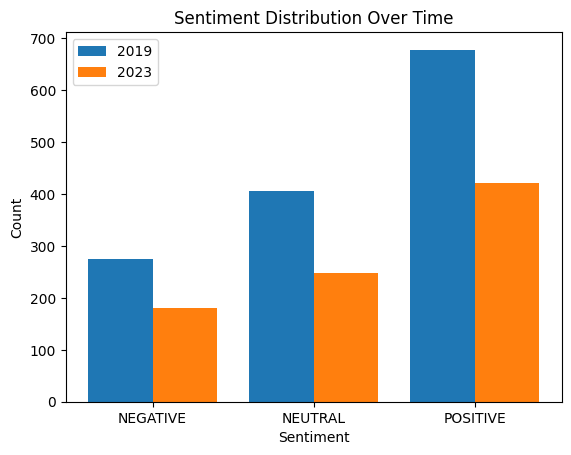

In [ ]:
#Ypologizoume ta statistika dedomena ton CSV poy ftiajame parapano + Sugkrinoyme over time allages sta sentiment (kanoyme 1 grafima opoy fenontai oi diagores gia to 2 etoi)

import matplotlib.pyplot as plt

def Statistics(year):
    #compute statistics
    global size

    path = "/content/gdrive/MyDrive/CSVS/sentiment_" + str(year) + ".csv"
    my_df = pd.read_csv(path)

    my_df = my_df.groupby("sentiment")["comments"].count() #upologizmos tou posa comment exei kathe katigoria (sentiment)
    my_df = my_df.reset_index()
    my_df.columns = ['Sentiment', 'Count'] #bazoyme tis stiles sto dataframe
    size = my_df['Count'].sum() #upologizoyme posa einai ta sunolika Comments
    my_df["Perentage"] = my_df["Count"].apply(persentage) #briskoume kai apothikeuoyme tis analogies gia kathe omada sxoleion se mia stilh
    return my_df

def compare_sentiment_over_time(df1 = Statistics(2019), df2 = Statistics(2023)):#compare the sentiment over time

    print(f"Statistcs 2019 \n{df1}")#print the statistics
    print(f"Statistcs 2023 \n{df2}")

    sentiment_1 = df1['Count']#get the count of the sentiment
    sentiment_2 = df2['Count']

    labels = df1['Sentiment']#get the labels
    x = range(len(labels))#get the range of the labels

    # Ensure that both arrays have the same length
    min_length = min(len(sentiment_1), len(sentiment_2))#get the min length
    sentiment_1 = sentiment_1[:min_length]#get the min length
    sentiment_2 = sentiment_2[:min_length]

    plt.bar(x, sentiment_1, width=0.4, label='2019')#plot the bar
    plt.bar([i + 0.4 for i in x], sentiment_2, width=0.4, label='2023')

    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Distribution Over Time')
    plt.xticks([i + 0.2 for i in x], labels)
    plt.legend()
    plt.show()

compare_sentiment_over_time()


In [ ]:
#Ερώτημα 2 (kai gia tis 2 xronies)

#Sunartisi (CSV_To_TSV) pou metatrepei to CSV se TSV kai to apothikeuei
#Sunartisi (load_tsv) kanei load to TSV poy theloyme
#Sunartisi (split) apla xorizei sta 2 to arxeio (80% train,20% test) kai kanei drop N/A grammes amma uparxoyn

from sklearn.model_selection import train_test_split

def CSV_To_TSV(year):#convert csv to tsv
    path = "/content/gdrive/MyDrive/CSVS/sentiment_" + str(year) + ".csv"#path
    my_df = pd.read_csv(path)#read the csv
    my_df = my_df.dropna()#drop nan values
    path = "/content/gdrive/MyDrive/TSVS/data_" + str(year) + ".tsv"
    my_df.to_csv(path, sep='\t', index=False)#save the tsv

CSV_To_TSV(2019)
CSV_To_TSV(2023)

def load_tsv(year):#load the tsv file
    path = "/content/gdrive/MyDrive/TSVS/data_" + str(year) + ".tsv"#path to the file
    data_tsv = pd.read_csv(path,sep='\t')#read the file
    return data_tsv

def split(year):
    my_df = load_tsv(year)#load the tsv file
    train_df, test_df = train_test_split(my_df, test_size=0.2, random_state=42)#split the data

    train_df = train_df.dropna()#drop the nan values
    test_df = test_df.dropna()#drop the nan values

    return train_df, test_df


In [ ]:
#TF-IDF function
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(year):
    #load the TSV
    train, test = split(year)#split the data

    train_sent = train["sentiment"]#get the sentiment
    test_sent = test["sentiment"]#get the sentiment

    TFIDF_vectorizer = TfidfVectorizer(max_features=1000)#initialize the TF-IDF vectorizer
    train_TFIDF = TFIDF_vectorizer.fit_transform(train["comments"]) #train the TF-IDF vectorizer with the train
    test_TFIDF = TFIDF_vectorizer.transform(test["comments"])#transform the test data

    return train_TFIDF, test_TFIDF, train_sent, test_sent

In [ ]:
#Word Embedding function
from gensim.models import Word2Vec
import numpy as np
from nltk.tokenize import word_tokenize

#pernoume kathe leksei se mia protasei prosthetoume ta antoistixa vector toys kai meta breiskoyme to MO prokeimenoy na exoyme sta xeria mas to Value olhs ths Protaseis
def get_average_word2vec(tokens_list, model, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectorized = [model.wv[word] if word in model.wv else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def text_to_word_list(text):
    text = text.lower().split()
    return text

#upologizmos toy Word_Embeddings gia ta comments mias xronias
def Word_Embeddings(year):

    train, test = split(year) #Load the TSV files

    train_sent = train["sentiment"]
    test_sent = test["sentiment"]

    model = Word2Vec(sentences=[word_tokenize(comment) for comment in train['comments']], vector_size=100, window=5, min_count=1, workers=4) #train the model

    train_embeddings = np.array([get_average_word2vec(text_to_word_list(comment), model) for comment in train['comments']])
    test_embeddings = np.array([get_average_word2vec(text_to_word_list(comment), model) for comment in test['comments']])

    return train_embeddings, test_embeddings, train_sent, test_sent


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, pairwise, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score

#upologizmos toy cros validation
def cross_validation(model_type, year):

    if model_type == "tfidf": #take the variables base on the model
        X_train, X_test, y_train, y_test = TFIDF(year)
    else:
        X_train, X_test, y_train, y_test = Word_Embeddings(year)

    models = {
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier()
    }

    print(f"resultes for year {year} with model type ({model_type})")

    for name, model in models.items():
        # Compute all scores for Cross Validation
        metrics = {
            'Precision': make_scorer(precision_score, pos_label=1, average='weighted', zero_division=0),
            'Recall': make_scorer(recall_score, pos_label=1, average='weighted', zero_division=0),
            'F_Measure': make_scorer(f1_score, pos_label=1, average='weighted', zero_division=0),
            'Accuracy': 'accuracy'
        }
        scores = {metric: float(np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring=scorer))) for metric, scorer in metrics.items()}
        scores["Name"] = name
        print(scores)

#cross validation gia 2019,2023 kai me tous 2 tropos TF-IDF,Word Embendings
cross_validation("tfidf",2019)
cross_validation("Word Embending",2019)
print("------------------------------------")
cross_validation("tfidf",2023)
cross_validation("Word Embending",2023)

resultes for year 2019 with model type (tfidf)
{'Precision': 0.7777101029010638, 'Recall': 0.7806150186884132, 'F_Measure': 0.7736917745292613, 'Accuracy': 0.7806150186884132, 'Name': 'SVM'}
{'Precision': 0.7580050306400244, 'Recall': 0.7603635745837581, 'F_Measure': 0.7386512010230535, 'Accuracy': 0.7484029901461094, 'Name': 'Random Forest'}
{'Precision': 0.4416962564160455, 'Recall': 0.31058443764865784, 'F_Measure': 0.1663696690057182, 'Accuracy': 0.31058443764865784, 'Name': 'KNN'}
resultes for year 2019 with model type (Word Embending)
{'Precision': 0.48291858521340564, 'Recall': 0.5263166836561333, 'F_Measure': 0.41786711654585734, 'Accuracy': 0.5263166836561333, 'Name': 'SVM'}
{'Precision': 0.6380095238192507, 'Recall': 0.6396024464831804, 'F_Measure': 0.6147608969639954, 'Accuracy': 0.6239381583418281, 'Name': 'Random Forest'}
{'Precision': 0.6022901666218807, 'Recall': 0.5788226299694189, 'F_Measure': 0.5527908995719104, 'Accuracy': 0.5788226299694189, 'Name': 'KNN'}
---------

    

* TF-IDF
    * Αξιολόγηση
        * SVM:Το SVM έχει την καλύτερη συνολική απόδοση από όλα τα μοντέλα. Έχει τον υψηλότερο βαθμό ακρίβειας (Precision) και ανάκλησης (Recall), καθώς και τη μεγαλύτερη ακρίβεια (Accuracy). Αυτό σημαίνει ότι το SVM είναι το πιο αξιόπιστο και αποτελεσματικό μοντέλο σε αυτή την περίπτωση.
        * Random Forest:Το Random Forest έρχεται δεύτερο σε απόδοση. Ενώ οι τιμές του (Precision) και (Recall) είναι αρκετά κοντά σε αυτές του SVM, η συνολική ακρίβειά του είναι ελαφρώς χαμηλότερη.
        * KNN:Το KNN έχει τη χαμηλότερη απόδοση από όλα τα μοντέλα. Οι τιμές του (Precision) και (Recall) είναι πολύ χαμηλές, όπως και η ακρίβειά του. Αυτό δείχνει ότι το KNN δεν είναι κατάλληλο για την συγκεκριμένη εργασία.
    * Συμπεράσματα
        * Καλύτερο Μοντέλο: Το SVM είναι ξεκάθαρα το καλύτερο μοντέλο για τα δεδομένα αυτά, με την υψηλότερη ακρίβεια και τις καλύτερες τιμές (Precision) και (Recall).
        * Εναλλακτική Επιλογή: Το Random Forest είναι μια καλή εναλλακτική επιλογή, εάν για κάποιο λόγο δεν μπορεί να χρησιμοποιηθεί το SVM.
        * Ανεπαρκές Μοντέλο: Το KNN δεν αποδίδει καλά και δεν είναι κατάλληλο για αυτή την εργασία.
        * Επομένως, για τα δεδομένα που έχουμε, το SVM είναι η προτιμώμενη επιλογή λόγω της ανώτερης απόδοσής του.
* Word Empbendings
    * Αξιολόγηση
        * SVM: Το SVM έχει τη χαμηλότερη απόδοση από τα τρία μοντέλα. Αν και έχει σχετικά καλό Recall, to (Precision) και η (F-Measure) του είναι χαμηλές. Αυτό υποδηλώνει ότι το μοντέλο μπορεί να εντοπίζει ένα καλό ποσοστό από τα σωστά παραδείγματα, αλλά έχει πολλά ψευδώς θετικά.
        * Random Forest:Το Random Forest αποδεικνύεται ως το καλύτερο μοντέλο. Έχει την υψηλότερη (Precision), (Recall), (F-Measure) και (Accuracy), γεγονός που δείχνει μια καλή ισορροπία μεταξύ της ακρίβειας και της δυνατότητας ανίχνευσης σωστών παραδειγμάτων.
        * KNN:Το KNN έχει καλύτερη απόδοση από το SVM, αλλά υπολείπεται σε σχέση με το Random Forest. To (Precision) και το (Recall) του είναι χαμηλότερα από του Random Forest, γεγονός που υποδηλώνει ότι το μοντέλο αυτό έχει μια μέτρια ικανότητα να εντοπίζει και να κατηγοριοποιεί σωστά τα παραδείγματα.
    * Συμπεράσματα
        * Καλύτερο Μοντέλο:Το Random Forest είναι το καλύτερο μοντέλο, με τις υψηλότερες τιμές (Precision), (Recall), (F-Measure) και (Accuracy). Είναι το πιο αξιόπιστο μοντέλο, που προσφέρει την καλύτερη ισορροπία μεταξύ ακρίβειας και ανίχνευσης σωστών παραδειγμάτων.
        * Εναλλακτική Επιλογή:Το KNN είναι μια αποδεκτή εναλλακτική λύση, αν και δεν είναι τόσο αποτελεσματικό όσο το Random Forest.
        * Ανεπαρκές Μοντέλο:Το SVM παρουσιάζει τη χαμηλότερη απόδοση και δεν είναι κατάλληλο για αυτή την εργασία σε σύγκριση με τα άλλα δύο μοντέλα.
        * Επομένως, για τα δεδομένα της εργασίας, το Random Forest είναι η προτιμώμενη επιλογή λόγω της ανώτερης απόδοσής του σε όλες τις μετρικές.
     

In [ ]:
#Ερώτημα 3) (Mono gia to 2019)
#Ebresei ton (number) pio emfanizomenon lekseon gia ta sxoleia mias xronias.Ypologizmos tou Cosine Similarity gia autes tiw lekseis (for year 2019 only).Kai exoyme kai mia sunartisi poy mas epistrefei
#mia lista me tis pio similar lekseis gia mia leksi (geitonia)
from sklearn.metrics.pairwise import cosine_similarity


def Most_Popular(number = 300):
    data_tsv = load_tsv(2019) #load TSV

    most_popular_voc = {}

    #upologismos tis sunxotitas emfanisis kathe lejeis
    for comment in data_tsv["comments"]:
        for word in word_tokenize(comment):
            if word not in most_popular_voc:
                most_popular_voc[word] = 1
            else:
                most_popular_voc[word] += 1

    #sortarisma ton lejeon simfona me thn emfanosh tous kai apothikeusei ton (number) kaliteron
    most_popular_voc = sorted(most_popular_voc.items(), key=lambda item: item[1],reverse=True)
    most_popular_voc = dict(most_popular_voc[:number])

    #epistrofi ton pio suxnon + train to modelo me ola ta dedomena
    return list(most_popular_voc.keys()), Word2Vec(sentences=[word_tokenize(comment) for comment in data_tsv['comments']], vector_size=100, window=5, min_count=1, workers=4)

def Compute_CosSim(most_popular_words,model): #cosine similarity for the Most Populat Words for the year we want

    vectorizer = [model.wv[word] for word in most_popular_words] #briskoume ta vectors gia kathe dimofili leksei
    vectorizer_array = np.array(vectorizer)
    similarity_array = cosine_similarity(vectorizer_array) #briskoyme to cosine similarity gia tis pio dimofilis lejeis

    return similarity_array

def Compute_Neigborhood(word, word_list, N, model):
    similar_words = []
    for w in word_list: #gia kathe dimofili lejei
        if w != word:   #amma den einai o eautos mas
            similarity = model.wv.similarity(word, w) #upologizoyme to similarity score
            similar_words.append((w, similarity))
    similar_words.sort(key=lambda x: x[1], reverse=True) #kanoyme sort tis lejeis simfona me to score

    return [w[0] for w in similar_words[:N]] #pernoume tis N protes




most_popular_words, model = Most_Popular()

similarity_array = Compute_CosSim(most_popular_words, model)

print(most_popular_words)

['apartment', 'great', 'place', 'us', 'stay', 'athens', 'location', 'host', 'good', 'nice', 'clean', 'would', 'everything', 'close', 'really', 'also', 'night', 'one', 'metro', 'time', 'acropolis', 'recommend', 'well', 'even', 'walk', 'get', 'flat', 'perfect', 'area', 'helpful', 'room', 'need', 'comfortable', 'restaurants', 'airbnb', 'located', 'house', 'city', 'view', 'like', 'could', 'station', 'shower', 'walking', 'around', 'definitely', 'amazing', 'bathroom', 'minutes', 'easy', 'back', 'bit', 'home', 'didnt', 'day', 'little', 'made', 'kitchen', 'small', 'water', 'days', 'people', 'bed', 'lot', 'building', 'highly', 'two', 'check', 'next', 'neighborhood', 'street', 'distance', 'center', 'away', 'spacious', 'airport', 'arrival', 'experience', 'noise', 'super', 'stayed', 'much', 'kind', 'thanks', 'best', 'staying', 'balcony', 'use', 'go', 'noisy', 'find', 'space', 'near', 'communication', 'wonderful', 'lovely', 'door', 'gave', 'central', 'first', 'main', 'problem', 'needed', 'quite', '

In [ ]:
#Ypologizoyme tis 3 sinartisis (1)Maximum Similarity of Neighborhoods (2)Correlation of Neighborhood Similarities (3)Sum of Squared Neighborhood Similarities

from scipy.stats import pearsonr
import math
import random

#a)Maximum Similarity of Neighborhoods
def max_sim_of_Neig(word1,word2,neig1,neig2,similarity_array,most_popular_words):
    #Mn(wi,wj) = max{αij,αji}
    sim1 = [similarity_array[most_popular_words.index(word1)][most_popular_words.index(w2)] for w2 in neig2] #S(wi,x) x ∈ Nj
    sim2 = [similarity_array[most_popular_words.index(word2)][most_popular_words.index(w1)] for w1 in neig1] #S(wj,y) y ∈ Ni

    max1 = sorted(sim1,reverse=True)[0] #αij = max S(wi,x) x ∈ Nj
    max2 = sorted(sim2,reverse=True)[0] #αij = max S(wj,y) y ∈ Ni

    return max(max1,max2) #max{αij , αji}

#b)Correlation of Neighborhood Similarities
def correlation_of_neighborhood(word1, word2, neig1, neig2, similarity_array, most_popular_words):
    #Rn(wi,wj) = max{βij,βji}
    same_word_neigh1 = [similarity_array[most_popular_words.index(word1)][most_popular_words.index(w1)] for w1 in neig1] #Ci στο Ni
    same_word_neigh2 = [similarity_array[most_popular_words.index(word2)][most_popular_words.index(w2)] for w2 in neig2] #Cj στο Nj

    different_word_neigh1 = [similarity_array[most_popular_words.index(word1)][most_popular_words.index(w2)] for w2 in neig2] #Ci στο Nj
    different_word_neigh2 = [similarity_array[most_popular_words.index(word2)][most_popular_words.index(w1)] for w1 in neig1] #Cj στο Ni

    correlation_coefficient1 = np.corrcoef(same_word_neigh1, different_word_neigh2)[0, 1] #ρ(Ci στο Ni,Cj στο Ni) βij
    correlation_coefficient2 = np.corrcoef(different_word_neigh1, same_word_neigh2)[0, 1] #ρ(Ci στο Nj,Cj στο Nj) βji

    return max(correlation_coefficient1,correlation_coefficient2) #max{βij,βji}

#c)Sum of Squared Neighborhood Similarities
def Sum_of_Sq_Neig_Sim(word1,word2,neig1,neig2,similarity_array,most_popular_words):
    # θ             θ           θ       1/θ
    #E(wi,wj) = (Σ S(wi,x) + Σ S(wj,y))
    # n        x ∈ Nj      y ∈ Ni
                                                                                                                  # 2
    sim1 = [similarity_array[most_popular_words.index(word1)][most_popular_words.index(w2)] ** 2 for w2 in neig2] #S(wi,x) x ∈ Nj
                                                                                                                  # 2
    sim2 = [similarity_array[most_popular_words.index(word2)][most_popular_words.index(w1)] ** 2 for w1 in neig1] #S(wj,y) y ∈ Ni

    sum1 = sum(sim1) #Σ sim1
    sum2 = sum(sim2) #Σ sim2

    Total_sum = sum1 + sum2
    return math.sqrt(Total_sum)

In [ ]:
#Sunartisi (Valid_Word) poy elenxei an mia lejei einai stis Most Popular,an oxi dialegei mia allh mesa apo autes tixea + elenxos estei oste na min einai kai oi 2 lejeis oi idies (poy sigkrinoyme)
#Sunartisi (Run_All_Similarity_Fun) pou upologizei tis geitonies shmfona me to N gia ta valid words ektiposi ton geitonion + ektiposi kai upologizmos ton Similarity me tous 3 diaforetikoys tropous

def Valid_Word(word1,word2,most_popular_words):
    if word1 not in most_popular_words: #if first word no in Popupal words
        word1 = random.choice(most_popular_words) #take a random value from the most Popupal words

    while word1 == word2: #in case both words is the same
        word1 = random.choice(most_popular_words)

    return word1

def Run_All_Similarity_Fun(word1,word2,N,similarity_array,most_popular_words):
    #check if example words is valid,if not take a valid one
    word1 = Valid_Word(word1,word2,most_popular_words)
    word2 = Valid_Word(word2,word1,most_popular_words)

    #compute neighborhood for the 2 words
    neig1 = Compute_Neigborhood(word1,most_popular_words,N,model)
    neig2 = Compute_Neigborhood(word2,most_popular_words,N,model)

    #print the neighborhood for each word in example
    print("-------------------------------------------")
    print(f"For the N={N} neighborhood")
    print(f"neighborhood words for '{word1}' is {neig1}")
    print(f"neighborhood words for '{word2}' is {neig2}")
    print("-------------------------------------------")

    #compute the similarity with all the functions
    Maximum_Similarity_of_Neighborhoods = max_sim_of_Neig(word1,word2,neig1,neig2,similarity_array,most_popular_words)
    Correlation_of_Neighborhood_Similarities = correlation_of_neighborhood(word1, word2, neig1, neig2, similarity_array, most_popular_words)
    Sum_of_Squared_Neighborhood_Similarities = Sum_of_Sq_Neig_Sim(word1,word2,neig1,neig2,similarity_array,most_popular_words)

    print(f"Maximum Similarity of Neighborhoods {Maximum_Similarity_of_Neighborhoods}")
    print(f"Correlation of Neighborhood Similarities {Correlation_of_Neighborhood_Similarities}")
    print(f"Sum of Squared Neighborhood Similarities {Sum_of_Squared_Neighborhood_Similarities}")

word1 = "xxxxx"
word2 = "yyyyy"

word1 = Valid_Word(word1,word2,most_popular_words)
word2 = Valid_Word(word2,word1,most_popular_words)

#example to see the diference between similarity base on diferent N(number of neighborhood)
Run_All_Similarity_Fun("extremely","would",2,similarity_array,most_popular_words)
Run_All_Similarity_Fun("extremely","would",10,similarity_array,most_popular_words)
Run_All_Similarity_Fun("extremely","would",30,similarity_array,most_popular_words)


#example that you can change whatever you want between (----------) Your example
#---------------------------------+
N = 10 #number of neighborhood  plz give above 1 [2,whatever you want]
word1 = 'Kalispera'
word2 = 'Holla'
#---------------------------------+
print("\n\nYour Example ")
Run_All_Similarity_Fun(word1,word2,N,similarity_array,most_popular_words)

-------------------------------------------
For the N=2 neighborhood
neighborhood words for 'extremely' is ['also', 'apartment']
neighborhood words for 'would' is ['place', 'athens']
-------------------------------------------
Maximum Similarity of Neighborhoods 0.99973464012146
Correlation of Neighborhood Similarities 1.0
Sum of Squared Neighborhood Similarities 1.9993695627690278
-------------------------------------------
For the N=10 neighborhood
neighborhood words for 'extremely' is ['also', 'apartment', 'door', 'people', 'day', 'airbnb', 'good', 'get', 'time', 'little']
neighborhood words for 'would' is ['place', 'athens', 'made', 'time', 'room', 'apartment', 'check', 'go', 'stay', 'two']
-------------------------------------------
Maximum Similarity of Neighborhoods 0.9997454285621643
Correlation of Neighborhood Similarities 0.3744405972876843
Sum of Squared Neighborhood Similarities 4.470609478198876
-------------------------------------------
For the N=30 neighborhood
neighbor

Συμφονα με το παραπανω παραδιγμα μπορουμε να κανουμε τις εξεις παρατιρισεις σχετικα με την αλλαγη των τιμων Similarity συμφονα με το N.

* Χαμιλο Ν (πχ Ν = 2)
    * Sum of Squared Neighborhood Similarities:Μπορουμε να δουμε οτι οσο χαμιλοτερο ειναι το Ν τοσο λιγοτερο ειναι και το Sum of Squared Neighborhood Similarities.
    * Maximum Similarity of Neighborhoods: Μπορουμε να δουμε οτι οσο χαμιλο και αν ειναι το Ν το Maximum Similarity of Neighborhoods παραμενει σχεδον ανεπαφο.
* Υψυλα Ν (πχ Ν = 30)
    * Sum of Squared Neighborhood Similarities: Μπορουμε να δουμε οτι οσο υψιλοτερ ειναι το Ν τοσο μεγαλυτερο ειναι και το Sum of Squared Neighborhood Similarities.
    * Maximum Similarity of Neighborhoods: Μπορουμε να δουμε οτι οσο μεγαλο και αν ειναι το Ν το Maximum Similarity of Neighborhoods παραμενει σχεδον ανεπαφο.

* Οσο και αν ειναι το Ν (πχ Ν=2 ή Ν=10 ή Ν=30) δεν μπορουμε να βγαλουμε καποιο πορισμα σχετικα με το Correlation of Neighborhood Similarities και την εξαρτιση που εχει με το Ν μιας και φενετε να μην επιρεαζετε με καποιο τροπο απο αυτο. Δεν φενετε στα αποτελεσματα του να υπαρχει καποιο εμφανης μοτιβο